In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
import cv2
import glob

2024-02-23 20:35:31.432230: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 20:35:31.520025: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 20:35:32.184101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 20:35:32.184606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 20:35:32.269276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
data_dir = '/home/aracely/aitraveling/cities'
labels = ["agra", "cdmx", "dubai", "newyork", "paris", "shanhaiguan", "sydney"]
for label in labels:
    image_count = len(glob.glob(data_dir+"/"+label+"/*"))
    print(label+": "+str(image_count))

agra: 503
cdmx: 381
dubai: 447
newyork: 410
paris: 248
shanhaiguan: 444
sydney: 510


In [3]:
images = {}
for label in labels:
    images[label] = glob.glob(data_dir+"/"+label+"/*")
# imgs_china = glob.glob(data_dir+"/china/*")
# imgs_india = glob.glob(data_dir+"/india/*")
# imgs_mexico = glob.glob(data_dir+"/mexico/*")

In [4]:
print(len(images["agra"]))

503


## Load data using a Keras utility

### Create a dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2946 files belonging to 7 classes.
Using 2357 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2946 files belonging to 7 classes.
Using 589 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']


## Visualize the data

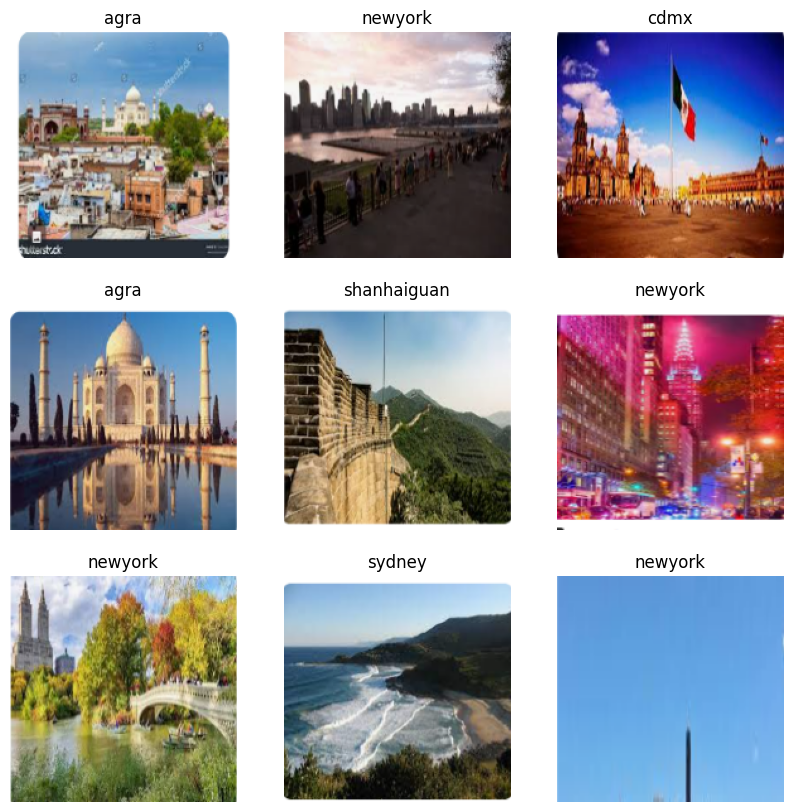

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9686275


## A basic Keras model

### Create the model

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
74/74 [==============================] - 19s 247ms/step - loss: 1.8754 - accuracy: 0.2304 - val_loss: 1.8257 - val_accuracy: 0.2649
Epoch 2/12
74/74 [==============================] - 17s 235ms/step - loss: 1.5815 - accuracy: 0.4141 - val_loss: 1.5617 - val_accuracy: 0.4194
Epoch 3/12
74/74 [==============================] - 18s 237ms/step - loss: 1.2983 - accuracy: 0.5244 - val_loss: 1.3938 - val_accuracy: 0.4941
Epoch 4/12
74/74 [==============================] - 17s 236ms/step - loss: 1.0314 - accuracy: 0.6436 - val_loss: 1.4514 - val_accuracy: 0.5212
Epoch 5/12
74/74 [==============================] - 18s 237ms/step - loss: 0.7673 - accuracy: 0.7391 - val_loss: 1.5108 - val_accuracy: 0.4771
Epoch 6/12
74/74 [==============================] - 17s 234ms/step - loss: 0.5536 - accuracy: 0.8112 - val_loss: 1.5418 - val_accuracy: 0.5348
Epoch 7/12
74/74 [==============================] - 18s 239ms/step - loss: 0.3085 - accuracy: 0.9028 - val_loss: 1.8415 - val_accuracy: 0.5467

## Visualize training results

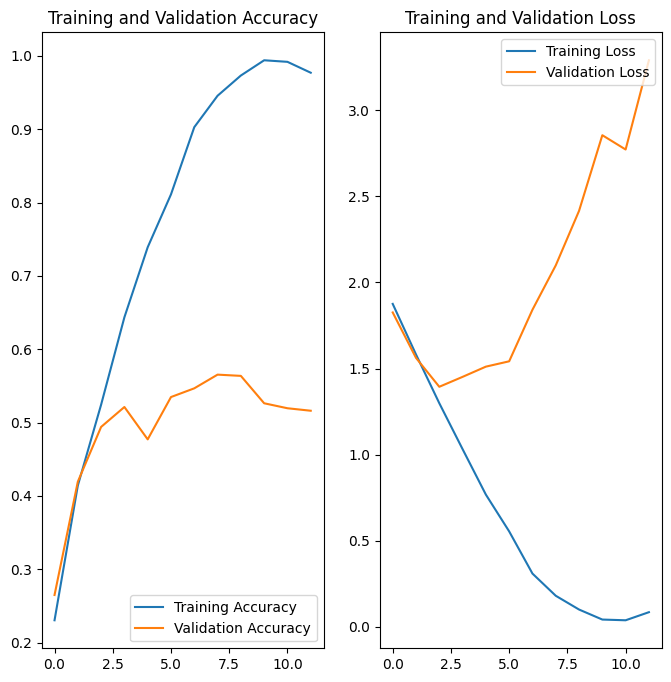

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

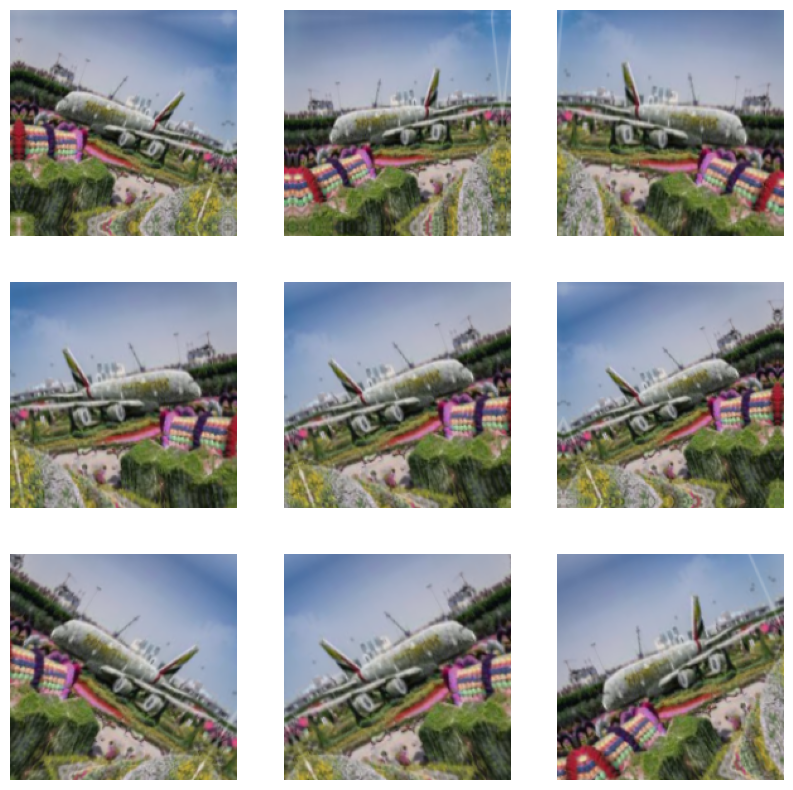

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
74/74 [==============================] - 23s 298ms/step - loss: 1.9546 - accuracy: 0.1964 - val_loss: 1.8216 - val_accuracy: 0.2716
Epoch 2/15
74/74 [==============================] - 24s 322ms/step - loss: 1.7699 - accuracy: 0.3042 - val_loss: 1.6719 - val_accuracy: 0.3667
Epoch 3/15
74/74 [==============================] - 22s 296ms/step - loss: 1.6282 - accuracy: 0.3729 - val_loss: 1.5253 - val_accuracy: 0.4194
Epoch 4/15
74/74 [==============================] - 22s 298ms/step - loss: 1.5346 - accuracy: 0.4251 - val_loss: 1.5129 - val_accuracy: 0.4601
Epoch 5/15
74/74 [==============================] - 22s 298ms/step - loss: 1.4698 - accuracy: 0.4429 - val_loss: 1.4759 - val_accuracy: 0.4533
Epoch 6/15
74/74 [==============================] - 22s 304ms/step - loss: 1.3822 - accuracy: 0.4900 - val_loss: 1.4450 - val_accuracy: 0.4584
Epoch 7/15
74/74 [==============================] - 22s 295ms/step - loss: 1.3376 - accuracy: 0.5121 - val_loss: 1.3626 - val_accuracy: 0.4924

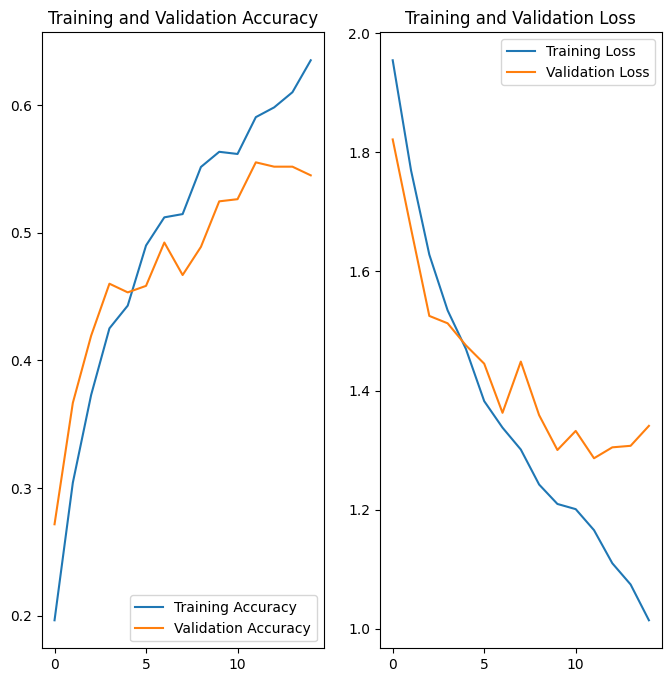

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [26]:
data_dir

'/home/aracely/aitraveling/cities'

1/1 [==============================] - 0s 135ms/step
This image most likely belongs to agra with a 45.03 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[0.45032367 0.06778428 0.34249166 0.01252741 0.00574571 0.00054744
 0.12057979]


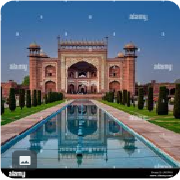

In [27]:
img = tf.keras.utils.load_img(
    data_dir+'/agra/(1105).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print()
print(class_names)
# print(type(score))
print(np.array(score))
img

1/1 [==============================] - 0s 150ms/step
This image most likely belongs to dubai with a 44.67 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[3.5212343e-04 4.4588044e-01 4.4674310e-01 7.3433347e-02 1.7668404e-02
 5.9673999e-04 1.5325865e-02]


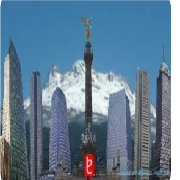

In [28]:
img2 = tf.keras.utils.load_img(
    data_dir+'/cdmx/(10130).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img2

1/1 [==============================] - 0s 31ms/step
This image most likely belongs to dubai with a 44.67 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[3.5212343e-04 4.4588044e-01 4.4674310e-01 7.3433347e-02 1.7668404e-02
 5.9673999e-04 1.5325865e-02]


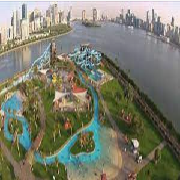

In [29]:
img = tf.keras.utils.load_img(
    data_dir+'/dubai/(10218).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

1/1 [==============================] - 0s 33ms/step
This image most likely belongs to newyork with a 79.52 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[2.0215821e-06 2.3853078e-02 1.6036236e-01 7.9522473e-01 1.5792828e-03
 4.2178576e-06 1.8974273e-02]


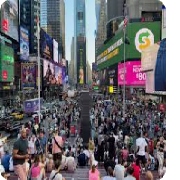

In [30]:
img3 = tf.keras.utils.load_img(
    data_dir+'/newyork/(10237).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img3

1/1 [==============================] - 0s 41ms/step
This image most likely belongs to cdmx with a 49.44 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[0.04587438 0.49436456 0.01164235 0.10600457 0.05653878 0.00190416
 0.2836712 ]


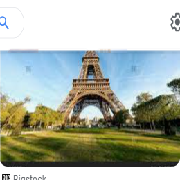

In [31]:
img4 = tf.keras.utils.load_img(
    data_dir+'/paris/(10239).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img4)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img4

1/1 [==============================] - 0s 35ms/step
This image most likely belongs to shanhaiguan with a 84.53 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[6.8731584e-02 5.7933372e-02 5.6406454e-04 1.8996533e-02 3.7276451e-04
 8.4525287e-01 8.1487345e-03]


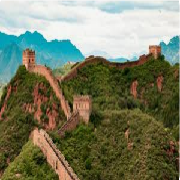

In [32]:
img5 = tf.keras.utils.load_img(
    data_dir+'/shanhaiguan/(10431).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img5

1/1 [==============================] - 0s 34ms/step
This image most likely belongs to shanhaiguan with a 84.53 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[6.8731584e-02 5.7933372e-02 5.6406454e-04 1.8996533e-02 3.7276451e-04
 8.4525287e-01 8.1487345e-03]


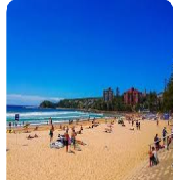

In [34]:
img = tf.keras.utils.load_img(
    data_dir+'/sydney/(10209).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

## Use TensorFlow Lite

### Convert the Keras Sequential model to a TensorFlow Lite model


In [35]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model7.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3vw2949x/assets


INFO:tensorflow:Assets written to: /tmp/tmp3vw2949x/assets
2024-02-23 20:50:20.836435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-23 20:50:20.836524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-23 20:50:20.837657: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3vw2949x
2024-02-23 20:50:20.841907: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-23 20:50:20.841942: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3vw2949x
2024-02-23 20:50:20.850799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-23 20:50:20.853562: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-23 20:50:20.968178: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

### Run the TensorFlow Lite model

In [36]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [159]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_7_input'], 'outputs': ['outputs']}}

In [160]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [161]:
predictions_lite = classify_lite(sequential_7_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

1/1 [==============================] - 0s 31ms/step
This image most likely belongs to shanhaiguan with a 82.05 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[1.1576256e-02 5.8558680e-02 1.9251764e-02 8.4572874e-02 7.1056950e-04
 8.2046789e-01 4.8620296e-03]


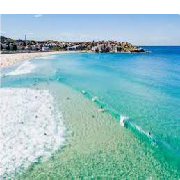

In [162]:
img = tf.keras.utils.load_img(
    data_dir+'/sydney/(10325).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

In [163]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to shanhaiguan with a 82.05 percent confidence.
